# Title: msticpy - Data
## Description:
This package provides functions to allow for the defining of data sources, connectors to them, and queries for them as well as the ability to call these elements to return query result from the defined data sources.
The package currently support connections to Log Analytics/Azure Sentinel/Azure Security Center, and the Microsoft Security Graph.

The first step in using this package is to install the msticpy package.

In [4]:
!pip install msticpy --upgrade --user

Successfully built msticpy


<a id='contents'></a>
## Table of Contents
* [Instantiating a Query Provider](#instantiating)
* [Connecting to a Data Environment](#connecting)
* [Reviewing available queries](#review_queries)
* [Running a pre-defined query](#run_query)
* [Running an ad-hoc query](#run_adhoc)
* [Creating a new set of queries](#new)
* [Adding a new set of queries and running them](#add_new)

In [1]:
#Check we are running Python 3.6
import sys
MIN_REQ_PYTHON = (3,6)
if sys.version_info < MIN_REQ_PYTHON:
    print('Check the Kernel->Change Kernel menu and ensure that Python 3.6')
    print('or later is selected as the active kernel.')
    sys.exit("Python %s.%s or later is required.\n" % MIN_REQ_PYTHON)

#imports
import yaml
import msticpy.nbtools as nbtools

#data library imports
from msticpy.data.data_providers import QueryProvider
import msticpy.data.data_query_reader as QueryReader
from msticpy.data.param_extractor import extract_query_params
import msticpy.nbtools as mas

print('Imports Complete')


Imports Complete


<a id='instantiating'></a>
### Instantiating a Query Provider
In order to connect to and query a data source we need to define what sort of Data Environment we want to connect to and query (in this Notebook we will use Log Analytics as an example). To view the options available you can call <code>QueryProvider.list_data_environments()</code> which will return a list of all the available options.

    
After selecting a Data Environment we can initialize our Query Provider by calling <code>QueryProvider(DATA_ENVIRONMENT)</code>. This will load the relavent driver for connecting to the data environment we have selected as well as provisioning a query store for us and adding queries from our default query directory. 

There are two other optional parameters we can pass when initializing our Query Providers to further customize it:
* We can also chose to initialize our Query Provider with a driver other than the defualt one with <code>QueryProvider(data_environment=DATA_ENVIRONMENT, driver=QUERY_DRIVER)</code>
* We can choose to import queries from a custom query directory (see - [Creating a new set of queries](#new) for more details) with <code>QueryProvider(data_environment=DATA_ENVIRONMENT, driver=QUERY_DRIVER, query_path=QUERY_DIRECTORY_PATH)</code>. 

For now we will simply create a Query Provider with default values.


    Query provider interface to queries.

        Parameters
        ----------
        data_environment : Union[str, DataEnvironment]
            Name or Enum of environment for the QueryProvider
        driver : DriverBase, optional
            Override the built-in driver (query execution class)
            and use your own driver (must inherit from
            `DriverBase`)

['LogAnalytics', 'Kusto', 'AzureSecurityCenter', 'SecurityGraph']
Please wait. Loading Kqlmagic extension...



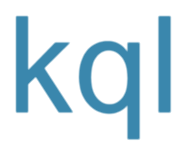

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
data_environments = QueryProvider.list_data_environments()
print(data_environments)
qry_prov = QueryProvider(data_environment='LogAnalytics')

<a id='connecting'></a>
### Connecting to a Data Environment
Once we have instantiated the query provider and loaded the relevent driver we can connect to the Data Environment. This is done by calling the <code>connect()</code> function of the Query Provider we just initialized and passing it a connection string to use.

For Log Analytics/Azure Sentinel the connection string is in the format of <code>loganalytics://code().tenant("TENANT_ID").workspace("WORKSPACE_ID")</code>. Other Data Environments will have different connection string formats.

    connect(self, connection_str: str, **kwargs):
       
        Connect to data source.

        Parameters
        ----------
        connection_string : str
            Connection string for the data source

In [3]:
ws_id = input('Workspace ID')
ten_id = input('Tenant ID')
la_connection_string = f'loganalytics://code().tenant("{ten_id}").workspace("{ws_id}")'
qry_prov.connect(connection_str=f'{la_connection_string}')

Workspace ID xxxxxxxxxxxxxxxxxxxxxxxxxxx
Tenant ID xxxxxxxxxxxxxxxxxxxxxxxxxxx


<IPython.core.display.Javascript object>

<a id='review_queries'></a>
### Reviewing available queries
Upon connecting to the relevant Data Environment we need to look at what query options we have available to us. In order to do this we can call <code>QUERY_PROVIDER.list_queries().</code> This will return a generator with the names of all the queries in our store.

The results returned show the data family the query belongs to and the name of the specific query.

    list_queries(self):
        
        Return list of family.query in the store.

        Returns
        -------
        Iterable[str]
            List of queries

In [3]:
queries = qry_prov.list_queries()
for query in queries:
    print(query)

LinuxSyslog.all_syslog
LinuxSyslog.cron_activity
LinuxSyslog.squid_activity
LinuxSyslog.sudo_activity
LinuxSyslog.user_group_activity
LinuxSyslog.user_logon
SecurityAlert.get_alert
SecurityAlert.list_alerts
SecurityAlert.list_alerts_counts
SecurityAlert.list_alerts_for_ip
SecurityAlert.list_related_alerts
WindowsSecurity.get_host_logon
WindowsSecurity.get_parent_process
WindowsSecurity.get_process_tree
WindowsSecurity.list_host_logon_failures
WindowsSecurity.list_host_logons
WindowsSecurity.list_host_processes
WindowsSecurity.list_hosts_matching_commandline
WindowsSecurity.list_matching_processes
WindowsSecurity.list_processes_in_session


To get further details on a specific query call <code>QUERY_PROVIDER.DATA_FAMILY.QUERY_NAME('?')</code> or <code>QUERY_PROVIDER.DATA_FAMILY.QUERY_NAME('help')</code>

This will display:
- Query Name
- What Data Environment it is designed for
- Short description of what the query does
- What parameter the query can be passed
- The raw query that will be run

In [5]:
qry_prov.SecurityAlert.list_alerts('?')

Query:  list_alerts
Data source:  LogAnalytics
Retrieves list of alerts

Parameters
----------
add_query_items: str (optional)
    Additional query clauses
end: datetime
    Query end time
path_separator: str (optional)
    Path separator
    (default value is: \\)
query_project: str (optional)
    Column project statement
    (default value is:  | project-rename StartTimeUtc = StartTime, EndTim...)
start: datetime
    Query start time
subscription_filter: str (optional)
    Optional subscription/tenant filter expression
    (default value is: true)
table: str (optional)
    Table name
    (default value is: SecurityAlert)
Query:
 {table} {query_project} | where {subscription_filter} | where TimeGenerated >= datetime({start}) | where TimeGenerated <= datetime({end}) | extend extendedProps = parse_json(ExtendedProperties) | extend CompromisedEntity = tostring(extendedProps["Compromised Host"]) | project-away extendedProps {add_query_items}


<a id='run_query'></a>
### Running an pre-defined query
To run a query from our query store we again call <code>QUERY_PROVIDER.DATA_FAMILY.QUERY_NAME(**Kwargs)</code> but this time we simply pass required parameters for that query as key word arguments.

This will return a Pandas DataFrame of the results with the columns determined by the query parameters. Should the query fail for some reason an exception will be raised.

In [11]:
alerts = qry_prov.SecurityAlert.list_alerts(start='2019-07-21 23:43:18.274492', end='2019-07-27 23:43:18.274492')
alerts.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,TenantId,TimeGenerated,AlertDisplayName,AlertName,Severity,Description,ProviderName,VendorName,VendorOriginalId,SystemAlertId,...,ExtendedProperties,Entities,SourceSystem,WorkspaceSubscriptionId,WorkspaceResourceGroup,ExtendedLinks,ProductName,ProductComponentName,Type,CompromisedEntity
0,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-07-22 06:35:13,Suspicious authentication activity,Suspicious authentication activity,Medium,"Although none of them succeeded, some of them ...",Detection,Microsoft,8af9954d-f28d-40ff-a079-d9d4cc5a5268,2518385291989119899_8af9954d-f28d-40ff-a079-d9...,...,"{\r\n ""Activity start time (UTC)"": ""2019/07/2...","[\r\n {\r\n ""$id"": ""4"",\r\n ""HostName"":...",Detection,3b701f84-d04b-4479-89b1-fa8827eb537e,sentineltest,"[\r\n {\r\n ""Href"": ""https://interflowwebp...",Azure Security Center,,SecurityAlert,
1,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-07-22 06:35:13,Suspicious authentication activity,Suspicious authentication activity,Medium,"Although none of them succeeded, some of them ...",Detection,Microsoft,8af9954d-f28d-40ff-a079-d9d4cc5a5268,5d60fff6-7dd2-4474-a4d0-4c8e3fa6fad6,...,"{\r\n ""Activity start time (UTC)"": ""2019/07/2...","[\r\n {\r\n ""$id"": ""4"",\r\n ""HostName"":...",Detection,3b701f84-d04b-4479-89b1-fa8827eb537e,sentineltest,"[\r\n {\r\n ""Href"": ""https://interflowwebp...",Azure Security Center,,SecurityAlert,
2,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-07-22 07:02:42,Traffic from unrecommended IP addresses was de...,Traffic from unrecommended IP addresses was de...,Low,Azure security center has detected incoming tr...,AdaptiveNetworkHardenings,Microsoft,ba07c315-0af5-4568-9ecd-6c788f9267ae,b7adb73b-0778-4929-b46a-c0ed642bc61f,...,"{\r\n ""Destination Port"": ""3389"",\r\n ""Proto...","[\r\n {\r\n ""$id"": ""4"",\r\n ""ResourceId...",Detection,,,"[\r\n {\r\n ""DetailBladeInputs"": ""protecte...",Azure Security Center,,SecurityAlert,
3,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-07-26 06:03:16,Traffic from unrecommended IP addresses was de...,Traffic from unrecommended IP addresses was de...,Low,Azure security center has detected incoming tr...,AdaptiveNetworkHardenings,Microsoft,c3144593-9bae-448e-87dd-b2d3c47de571,d89ad3b2-f7a7-4cff-b8a4-3f6fa58b4760,...,"{\r\n ""Destination Port"": ""22"",\r\n ""Protoco...","[\r\n {\r\n ""$id"": ""4"",\r\n ""ResourceId...",Detection,,,"[\r\n {\r\n ""DetailBladeInputs"": ""protecte...",Azure Security Center,,SecurityAlert,
4,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-07-23 06:42:01,Traffic from unrecommended IP addresses was de...,Traffic from unrecommended IP addresses was de...,Low,Azure security center has detected incoming tr...,AdaptiveNetworkHardenings,Microsoft,4e4173a6-1a27-451f-8a3c-25d10b306c30,11813ab7-ab7c-4719-b0a1-ccb5d4a32223,...,"{\r\n ""Destination Port"": ""3389"",\r\n ""Proto...","[\r\n {\r\n ""$id"": ""4"",\r\n ""ResourceId...",Detection,,,"[\r\n {\r\n ""DetailBladeInputs"": ""protecte...",Azure Security Center,,SecurityAlert,


It is also possible to pass queries objects as arguments before defining keywork arguments. 
For example if I wanted to define query times as an object rather than defining a start and end via keywork arguments I could simply pass a querytimes object to the pre-defined query.

In [8]:
query_times = mas.nbwidgets.QueryTime(units='day',  
                            max_before=40, max_after=1, before=5)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [10]:
qry_prov.SecurityAlert.list_alerts(query_times)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,TenantId,TimeGenerated,AlertDisplayName,AlertName,Severity,Description,ProviderName,VendorName,VendorOriginalId,SystemAlertId,...,ExtendedProperties,Entities,SourceSystem,WorkspaceSubscriptionId,WorkspaceResourceGroup,ExtendedLinks,ProductName,ProductComponentName,Type,CompromisedEntity
0,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-07-26 06:03:16,Traffic from unrecommended IP addresses was de...,Traffic from unrecommended IP addresses was de...,Low,Azure security center has detected incoming tr...,AdaptiveNetworkHardenings,Microsoft,c3144593-9bae-448e-87dd-b2d3c47de571,d89ad3b2-f7a7-4cff-b8a4-3f6fa58b4760,...,"{\r\n ""Destination Port"": ""22"",\r\n ""Protoco...","[\r\n {\r\n ""$id"": ""4"",\r\n ""ResourceId...",Detection,,,"[\r\n {\r\n ""DetailBladeInputs"": ""protecte...",Azure Security Center,,SecurityAlert,
1,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-07-23 06:42:01,Traffic from unrecommended IP addresses was de...,Traffic from unrecommended IP addresses was de...,Low,Azure security center has detected incoming tr...,AdaptiveNetworkHardenings,Microsoft,4e4173a6-1a27-451f-8a3c-25d10b306c30,11813ab7-ab7c-4719-b0a1-ccb5d4a32223,...,"{\r\n ""Destination Port"": ""3389"",\r\n ""Proto...","[\r\n {\r\n ""$id"": ""4"",\r\n ""ResourceId...",Detection,,,"[\r\n {\r\n ""DetailBladeInputs"": ""protecte...",Azure Security Center,,SecurityAlert,
2,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-07-22 06:35:13,Suspicious authentication activity,Suspicious authentication activity,Medium,"Although none of them succeeded, some of them ...",Detection,Microsoft,8af9954d-f28d-40ff-a079-d9d4cc5a5268,2518385291989119899_8af9954d-f28d-40ff-a079-d9...,...,"{\r\n ""Activity start time (UTC)"": ""2019/07/2...","[\r\n {\r\n ""$id"": ""4"",\r\n ""HostName"":...",Detection,3b701f84-d04b-4479-89b1-fa8827eb537e,sentineltest,"[\r\n {\r\n ""Href"": ""https://interflowwebp...",Azure Security Center,,SecurityAlert,
3,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-07-22 06:35:13,Suspicious authentication activity,Suspicious authentication activity,Medium,"Although none of them succeeded, some of them ...",Detection,Microsoft,8af9954d-f28d-40ff-a079-d9d4cc5a5268,5d60fff6-7dd2-4474-a4d0-4c8e3fa6fad6,...,"{\r\n ""Activity start time (UTC)"": ""2019/07/2...","[\r\n {\r\n ""$id"": ""4"",\r\n ""HostName"":...",Detection,3b701f84-d04b-4479-89b1-fa8827eb537e,sentineltest,"[\r\n {\r\n ""Href"": ""https://interflowwebp...",Azure Security Center,,SecurityAlert,
4,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-07-22 07:02:42,Traffic from unrecommended IP addresses was de...,Traffic from unrecommended IP addresses was de...,Low,Azure security center has detected incoming tr...,AdaptiveNetworkHardenings,Microsoft,ba07c315-0af5-4568-9ecd-6c788f9267ae,b7adb73b-0778-4929-b46a-c0ed642bc61f,...,"{\r\n ""Destination Port"": ""3389"",\r\n ""Proto...","[\r\n {\r\n ""$id"": ""4"",\r\n ""ResourceId...",Detection,,,"[\r\n {\r\n ""DetailBladeInputs"": ""protecte...",Azure Security Center,,SecurityAlert,


<a id='run_adhoc'></a>
###  Running an ad-hoc query
It is also possible to run ad-hoc queries via a similar method. Rather than calling a named query from the Query Provider query store, we can pass a query directly to our Query Provider with <code>QUERY_PROVIDER.exec_query(query=QUERY_STRING)</code>. This will execute the query string passed in the parameters with the driver contained in the Query Provider and return data in a Pandas DataFrame. As with predefined queries an exception will be raised should the query fail to execute.

    query(self, query: str) -> Union[pd.DataFrame, Any]:
        Execute query string and return DataFrame of results.

        Parameters
        ----------
        query : str
            The kql query to execute

        Returns
        -------
        Union[pd.DataFrame, results.ResultSet]
            A DataFrame (if successful) or
            Kql ResultSet if an error.

In [12]:
test_query = '''
    SecurityAlert
    | take 5
    '''

query_test = qry_prov.exec_query(query=test_query)
query_test.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,TenantId,TimeGenerated,DisplayName,AlertName,AlertSeverity,Description,ProviderName,VendorName,VendorOriginalId,SystemAlertId,...,RemediationSteps,ExtendedProperties,Entities,SourceSystem,WorkspaceSubscriptionId,WorkspaceResourceGroup,ExtendedLinks,ProductName,ProductComponentName,Type
0,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-07-22 06:35:13,Suspicious authentication activity,Suspicious authentication activity,Medium,"Although none of them succeeded, some of them ...",Detection,Microsoft,8af9954d-f28d-40ff-a079-d9d4cc5a5268,2518385291989119899_8af9954d-f28d-40ff-a079-d9...,...,"[\r\n ""1. Enforce the use of strong passwords...","{\r\n ""Activity start time (UTC)"": ""2019/07/2...","[\r\n {\r\n ""$id"": ""4"",\r\n ""HostName"":...",Detection,3b701f84-d04b-4479-89b1-fa8827eb537e,sentineltest,"[\r\n {\r\n ""Href"": ""https://interflowwebp...",Azure Security Center,,SecurityAlert
1,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-07-22 06:35:13,Suspicious authentication activity,Suspicious authentication activity,Medium,"Although none of them succeeded, some of them ...",Detection,Microsoft,8af9954d-f28d-40ff-a079-d9d4cc5a5268,5d60fff6-7dd2-4474-a4d0-4c8e3fa6fad6,...,"[\r\n ""1. Enforce the use of strong passwords...","{\r\n ""Activity start time (UTC)"": ""2019/07/2...","[\r\n {\r\n ""$id"": ""4"",\r\n ""HostName"":...",Detection,3b701f84-d04b-4479-89b1-fa8827eb537e,sentineltest,"[\r\n {\r\n ""Href"": ""https://interflowwebp...",Azure Security Center,,SecurityAlert
2,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-07-22 07:02:42,Traffic from unrecommended IP addresses was de...,Traffic from unrecommended IP addresses was de...,Low,Azure security center has detected incoming tr...,AdaptiveNetworkHardenings,Microsoft,ba07c315-0af5-4568-9ecd-6c788f9267ae,b7adb73b-0778-4929-b46a-c0ed642bc61f,...,"[\r\n ""1. Review the IP addresses and determi...","{\r\n ""Destination Port"": ""3389"",\r\n ""Proto...","[\r\n {\r\n ""$id"": ""4"",\r\n ""ResourceId...",Detection,,,"[\r\n {\r\n ""DetailBladeInputs"": ""protecte...",Azure Security Center,,SecurityAlert
3,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-07-26 06:03:16,Traffic from unrecommended IP addresses was de...,Traffic from unrecommended IP addresses was de...,Low,Azure security center has detected incoming tr...,AdaptiveNetworkHardenings,Microsoft,c3144593-9bae-448e-87dd-b2d3c47de571,d89ad3b2-f7a7-4cff-b8a4-3f6fa58b4760,...,"[\r\n ""1. Review the IP addresses and determi...","{\r\n ""Destination Port"": ""22"",\r\n ""Protoco...","[\r\n {\r\n ""$id"": ""4"",\r\n ""ResourceId...",Detection,,,"[\r\n {\r\n ""DetailBladeInputs"": ""protecte...",Azure Security Center,,SecurityAlert
4,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-06-27 00:31:35,Security incident with shared process detected,Security incident with shared process detected,High,The incident which started on 2019-06-25 21:24...,Detection,Microsoft,be88b671-2572-4373-af4a-323849b1da1d,2518408029550429999_be88b671-2572-4373-af4a-32...,...,"[\r\n ""1. Escalate the alert to the informati...","{\r\n ""isincident"": ""true"",\r\n ""Detected Ti...","[\r\n {\r\n ""$id"": ""4"",\r\n ""DisplayNam...",Detection,3b701f84-d04b-4479-89b1-fa8827eb537e,sentineltest,,Azure Security Center,,SecurityAlert


<a id='new'></a>
### Creating a new set of queries
msticpy provides a number of pre-defined queries to call with using the data package. You can also add in additional queries to be imported and used by your Query Provider, these are defined in YAML format files and examples of these files can be found at the msticpy GitHub site https://github.com/microsoft/msticpy/tree/master/msticpy/data/queries. 

The required structure of these query definition files is as follows:
- metadata
    - version: The version number of the definition file
    - description: A description of the purpose of this collection of query definitions
    - data_environments[]: A list of the Data Environments that the defined queries can be run against (1 or more)
    - data_families[]: A list of Data Families the defined queries related to, these families are defined as part of misticpy.nbtools.query_defns
    - tags[]: A list of tags to help manage definition files
- defaults: A set of defaults that apply to all queries in the file
    - metadata: Metadata regarding a query
        - data_source: The data source to be used for the query
    - parameters: Parameters to be passed to the query
        - name: The parameter name
        - description: A description of what the parameter is
        - type: The data type of the parameter
        - default: The default value for that parameter
- sources: a set of queries
    - name: The name of the query
        -description: A description of the query's function
        -metadata: Any metadata associated with the query
        -args: The arguments of the query
            -query: The query to be executed
            -uri: A URI associated with the query
        -parameters: Any parameters required by the query not covered by defaults
            - name: The parameter name
            - description: A description of what the parameter is
            - type: The data type of the parameter
            - default: The default value for that parameter
            

There are also a number of tools within the package to assist in validating new query definition files once created.
    
    data_query_reader.find_yaml_files
        
        Return iterable of yaml files found in `source_path`.

        Parameters
        ----------
        source_path : str
            The source path to search in.
        recursive : bool, optional
            Whether to recurse through subfolders.
            By default False

        Returns
        -------
        Iterable[str]
            File paths of yaml files found.
            
     data_query_reader.validate_query_defs
         
         Validate content of query definition.

        Parameters
        ----------
        query_def_dict : dict
            Dictionary of query definition yaml file contents.

        Returns
        -------
        bool
            True if validation succeeds.

        Raises
        ------
        ValueError
            The validation failure reason is returned in the
            exception message (arg[0])

<code>validate_query_defs()</code> does not perform comprehensive checks on the file but does check key elements required in the file are present.

In [13]:
for file in QueryReader.find_yaml_files(source_path="C:\\queries"):
    with open(file) as f_handle:
        yaml_file = yaml.safe_load(f_handle)
        if QueryReader.validate_query_defs(query_def_dict = yaml_file) == True:
            print(f' {file} is a valid query definition')
        else:
            print(f'There is an error with {file}')

 C:\queries\example.yaml is a valid query definition


<a id='add_new'></a>
### Adding a new set of queries and running them
Once you are happy with a query definition file then you import it with <code>QUERY_PROVIDER.import_query_file(query_file=PATH_TO_QUERY_FILE)</code>
This will load the query file into the Query Provider's Query Store from where it can be called.

In [16]:
qry_prov.import_query_file(query_file='C:\queries\example.yaml')

Once imported the queries in the files appear in the Query Provider's Query Store alongside the others and can be called in the same manner as pre-defined queries.

If you have created a large number of query definition files and you want to have the automatically imported into a Query Provider's query store at initialization you can specify a directory containing these queries in the msticpyconfig.yaml file under QueryDefinitions: Custom: 

For example if I have a folder at C:\queries I will set the config file to:

 QueryDefinitions:
  Default: "queries"
  Custom: 
    - "C:\\queries"
    - "C:\\queries2 

 
Having the Custom field populated will mean the Query Provider will automatically enumerate all the YAML files in the directory provided and automatically import he relevant queries into the query store at initialization alongside the default queries. Custom queries with the same name as default queries will overwrite default queries.

In [18]:
queries = qry_prov.list_queries()
for query in queries:
    print(query)

LinuxSyslog.all_syslog
LinuxSyslog.cron_activity
LinuxSyslog.squid_activity
LinuxSyslog.sudo_activity
LinuxSyslog.syslog_example
LinuxSyslog.user_group_activity
LinuxSyslog.user_logon
SecurityAlert.get_alert
SecurityAlert.list_alerts
SecurityAlert.list_alerts_counts
SecurityAlert.list_alerts_for_ip
SecurityAlert.list_related_alerts
WindowsSecurity.get_host_logon
WindowsSecurity.get_parent_process
WindowsSecurity.get_process_tree
WindowsSecurity.list_host_logon_failures
WindowsSecurity.list_host_logons
WindowsSecurity.list_host_processes
WindowsSecurity.list_hosts_matching_commandline
WindowsSecurity.list_matching_processes
WindowsSecurity.list_processes_in_session


In [19]:
qry_prov.LinuxSyslog.syslog_example('?')

Query:  syslog_example
Data source:  LogAnalytics
Example query

Parameters
----------
add_query_items: str (optional)
    Additional query clauses
end: datetime
    Query end time
host_name: str
    Hostname to query for
query_project: str (optional)
    Column project statement
    (default value is:  | project TenantId, Computer, Facility, TimeGener...)
start: datetime
    Query start time
subscription_filter: str (optional)
    Optional subscription/tenant filter expression
    (default value is: true)
table: str (optional)
    Table name
    (default value is: Syslog)
Query:
 {table} | where {subscription_filter} | where TimeGenerated >= datetime({start}) | where TimeGenerated <= datetime({end}) | where Computer == "{host_name}" | take 5


In [23]:
qry_prov.LinuxSyslog.syslog_example(start='2019-07-21 23:43:18.274492', end='2019-07-27 23:43:18.274492', host_name='UbuntuDevEnv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,TenantId,SourceSystem,TimeGenerated,Computer,EventTime,Facility,HostName,SeverityLevel,SyslogMessage,ProcessID,HostIP,ProcessName,MG,Type,_ResourceId
0,b1315f05-4a7a-45b4-811f-73e715f7c122,Linux,2019-07-25 15:15:37.213,UbuntuDevEnv,2019-07-25 15:15:37,authpriv,UbuntuDevEnv,notice,omsagent : TTY=unknown PWD=/opt/microsoft/om...,NaN,10.0.1.4,sudo,00000000-0000-0000-0000-000000000002,Syslog,/subscriptions/3b701f84-d04b-4479-89b1-fa8827e...
1,b1315f05-4a7a-45b4-811f-73e715f7c122,Linux,2019-07-25 15:15:37.313,UbuntuDevEnv,2019-07-25 15:15:37,authpriv,UbuntuDevEnv,info,pam_unix(sudo:session): session opened for use...,NaN,10.0.1.4,sudo,00000000-0000-0000-0000-000000000002,Syslog,/subscriptions/3b701f84-d04b-4479-89b1-fa8827e...
2,b1315f05-4a7a-45b4-811f-73e715f7c122,Linux,2019-07-25 15:15:37.917,UbuntuDevEnv,2019-07-25 15:15:37,authpriv,UbuntuDevEnv,info,pam_unix(sudo:session): session closed for use...,NaN,10.0.1.4,sudo,00000000-0000-0000-0000-000000000002,Syslog,/subscriptions/3b701f84-d04b-4479-89b1-fa8827e...
3,b1315f05-4a7a-45b4-811f-73e715f7c122,Linux,2019-07-25 15:15:50.793,UbuntuDevEnv,2019-07-25 15:15:50,authpriv,UbuntuDevEnv,info,pam_unix(cron:session): session closed for use...,29486.0,10.0.1.4,CRON,00000000-0000-0000-0000-000000000002,Syslog,/subscriptions/3b701f84-d04b-4479-89b1-fa8827e...
4,b1315f05-4a7a-45b4-811f-73e715f7c122,Linux,2019-07-25 15:16:01.800,UbuntuDevEnv,2019-07-25 15:16:01,authpriv,UbuntuDevEnv,info,pam_unix(cron:session): session opened for use...,29844.0,10.0.1.4,CRON,00000000-0000-0000-0000-000000000002,Syslog,/subscriptions/3b701f84-d04b-4479-89b1-fa8827e...


If you are having difficulties with a defined query and it is not producing the expected results it can be useful to see the raw query exactly as it is passed to the Data Environment. If you call a query with 'print' and the parameters required by that query it will construct and print out the query string to be run. 

In [25]:
qry_prov.LinuxSyslog.syslog_example('print', start='2019-07-21 23:43:18.274492', end='2019-07-27 23:43:18.274492', host_name='UbuntuDevEnv')

' Syslog | where true | where TimeGenerated >= datetime(2019-07-21 23:43:18.274492) | where TimeGenerated <= datetime(2019-07-27 23:43:18.274492) | where Computer == "UbuntuDevEnv" | take 5'